In [1]:
import math
import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumRegister, QuantumCircuit, execute, Aer
from scipy.linalg import lapack
from src.rdmg import rdm_ginibre
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import state_fidelity
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

/tmp/ipykernel_24463/1428247323.py:11: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [2]:
# nshots = 8192
nshots = 10000
IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# provider = qiskit.IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
device = provider.get_backend('ibmq_quito')
# device = provider.get_backend('ibmq_jakarta')
simulator = Aer.get_backend('qasm_simulator')


In [3]:
def get_abs_lambda(rho):

    n = np.shape(rho)[0]
    w, u, _ = lapack.zheev(rho, overwrite_a=True)
    psi = 0
    for i in range(len(u)):
        u[:, i] = u[:, i]/np.linalg.norm(u[:, i])
    for i in range(n):
        # rho += w[i] * np.outer(u[:, i], u[:, i].conj()) # se precisar do rho
        psi += math.sqrt(w[i])*np.eye(n)[:, i]
    return psi, u


In [4]:
def get_rho_circuit(psi, rho, u):
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    if n_qubits == 1:
        lista = [qr[0]]
    else:
        lista = []
        for i in range(n_qubits):
            lista.append(qr[i])
    U_op = Operator(u)
    qc = QuantumCircuit(qr, name='qc_initialize')

    qc.initialize(psi, lista)
    for i in range(int(n_qubits)):
        qc.cx(i, int(n_qubits)+i)
    qc.append(U_op,   list(range(n_qubits)))

    return qc


In [5]:

rho = rdm_ginibre(4)
n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
d = int(2*n_qubits)
qr = QuantumRegister(d)
qc = QuantumCircuit(qr)
psi, u = get_abs_lambda(rho)
qc_ = get_rho_circuit(psi, rho, u)
qc.append(qc_, [qr[0], qr[1], qr[2], qr[3]])

# [qr[0],qr[1]]circuito para TEQ
qstc = state_tomography_circuits(qc, [qr[0], qr[1]])
job_sim = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
print(job_sim.job_id())
job_monitor(job_sim)
qstf = StateTomographyFitter(job_sim.result(), qstc)  # ajusta os dados
rhoDCBA = qstf.fit(method='lstsq')  # extrai o operador densidade
# fidelidade entre estado tomografado e rhogerado aleatóriamente
fid = state_fidelity(rho, rhoDCBA)
print(rhoDCBA)
print(fid)


fef745cc-6241-43c0-af09-fbb0de9b2074
Job Status: job has successfully run
[[ 0.12318933+0.j          0.02005828+0.0091536j  -0.02524633+0.03366132j
   0.03750335+0.14288918j]
 [ 0.02005828-0.0091536j   0.27369487+0.j          0.0174135 -0.00018252j
  -0.03974049-0.01568582j]
 [-0.02524633-0.03366132j  0.0174135 +0.00018252j  0.20774786+0.j
  -0.07512922-0.02433365j]
 [ 0.03750335-0.14288918j -0.03974049+0.01568582j -0.07512922+0.02433365j
   0.39536794+0.j        ]]
0.9997217265540171


In [6]:
# definir o número de matrizes a serem geradas
n_matrices = 10

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(8)

    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)

    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0], qr[1], qr[2]])

    # executar os circuitos de tomografia
    job_sim = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    print(job_sim.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_sim)

    # ajustar os dados
    qstf = StateTomographyFitter(job_sim.result(), qstc)

    # extrair o operador densidade
    rhoDCBA = qstf.fit(method='lstsq')
    print("Matriz {}:".format(i+1))
    print(rhoDCBA)

    # calcular a fidelidade
    fid = state_fidelity(rho, rhoDCBA)
    print("Fidelidade: {}".format(fid))


19e38f0a-6f5c-4631-bec3-41c0bb8ff1f4
Job Status: job has successfully run
Matriz 1:
[[ 0.1043963 +0.j         -0.05691193-0.03527432j -0.0048745 -0.04425601j
   0.04055944+0.02624084j  0.00696002-0.01689894j -0.01395938+0.06587002j
  -0.03313084+0.04461208j  0.00592503+0.01126045j]
 [-0.05691193+0.03527432j  0.13013413+0.j          0.01345884+0.06372346j
  -0.07690335+0.03943101j  0.01813558-0.03973557j  0.01972423+0.02278038j
  -0.02273224-0.03706798j -0.05817581-0.00527345j]
 [-0.0048745 +0.04425601j  0.01345884-0.06372346j  0.11260914+0.j
   0.00396925+0.00765735j -0.01323899+0.01555211j -0.02578813-0.00221174j
  -0.02971599+0.00134496j  0.00048582+0.05369616j]
 [ 0.04055944-0.02624084j -0.07690335-0.03943101j  0.00396925-0.00765735j
   0.1219448 +0.j         -0.05649848+0.00162118j  0.02756286-0.05435738j
   0.02821993+0.02840043j  0.01059279-0.00697026j]
 [ 0.00696002+0.01689894j  0.01813558+0.03973557j -0.01323899-0.01555211j
  -0.05649848-0.00162118j  0.16676165+0.j         -0.0

In [7]:
display(rho)

array([[ 0.10144945+0.j        , -0.00335146+0.01043935j,
         0.05822217-0.00207621j, -0.03508779+0.01127257j,
         0.03430579-0.02655388j,  0.00081601+0.03367612j,
         0.00630263-0.0041307j , -0.02292301+0.04705203j],
       [-0.00335146-0.01043935j,  0.08924957+0.j        ,
        -0.02343214-0.00337045j,  0.01936042+0.03972829j,
         0.03539718-0.0604157j ,  0.04010991+0.07377586j,
         0.00607857+0.01669923j,  0.0743512 +0.01764836j],
       [ 0.05822217+0.00207621j, -0.02343214+0.00337045j,
         0.11439231+0.j        , -0.01425063-0.0013329j ,
         0.03463515-0.02220228j, -0.02901102+0.04692432j,
        -0.02171845-0.0193999j , -0.02624419+0.06094086j],
       [-0.03508779-0.01127257j,  0.01936042-0.03972829j,
        -0.01425063+0.0013329j ,  0.07841534+0.j        ,
        -0.04500575-0.03215482j,  0.07166134+0.0100561j ,
        -0.01152785-0.00881613j,  0.02876337-0.03941478j],
       [ 0.03430579+0.02655388j,  0.03539718+0.0604157j ,
         0

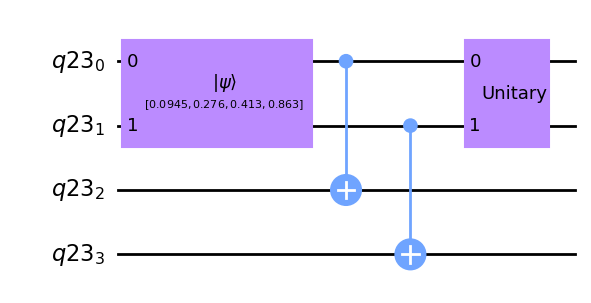

In [9]:
# run example
rho = rdm_ginibre(4)
psi, u = get_abs_lambda(rho)
qc = get_rho_circuit(psi, rho, u)
qc.draw(output='mpl')

# End